In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import numpy as np
import pandas as pd
import prettyplotlib as ppl
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern Roman'], 'size':14})
rc('text', usetex=True)

In [20]:
# read in dataframe
df = pd.read_csv('final_data_files/all_data.csv')#_clipped.csv')
df = df[df.photfeh_err <= 0.3]
print df[df.resid_all_h == df.resid_all_h.min()]

      id  type       per  mag_j  merr_j      mag_h    merr_h      mag_k  \
66  84.0   0.0  0.579873    NaN     NaN  12.833301  0.017239  12.781078   

      merr_k  mag_3      ...       merr_4  resid_all_j  resid_all_h  \
66  0.015706    NaN      ...          NaN          NaN    -0.455636   

    resid_all_k  resid_all_3  resid_all_4  photfeh  photfeh_err  spectfeh  \
66     -0.46099          NaN          NaN    -1.47          0.1       NaN   

    spectfeh_err  
66           NaN  

[1 rows x 22 columns]


In [33]:
# define line-fitting function
def fitfunc(x,slope,intc):
    return slope*x + intc

# make the figure and subplots

def make_plot(wav, df, lam):
    resid_name = 'resid_all_{}'.format(wav.lower())
    merr_name = 'merr_{}'.format(wav.lower())
    condition_1 = (np.isfinite(df[resid_name]))
    # select only rows with non-nan spectroscopic metallicities
    # condition_2 = (np.isfinite(df.spectfeh))
    # select only rows with non-nan photometric metallicities
    condition_3 = (np.isfinite(df.photfeh))
    condition_4 = (df.type == 0)
    
    df2 = df[condition_1 & condition_3 & condition_4] # photometric rrab
    df4 = df[condition_1 & condition_3 & ~condition_4] # photometric rrc
    
    resids2 = [df2[resid_name], df4[resid_name]]
    fehs2 = [df2['photfeh'], df4['photfeh']]
    resid_errs2 = [df2[merr_name], df4[merr_name]]
    feh_errs2 = [df2['photfeh_err'], df4['photfeh_err']]
    labels = ['RRab', 'RRc']

    fig, ax = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(8,3))
    ax = ax.ravel()
    ax[0].set_ylim(-0.85,0.85)
    #ax1.set_xlim(-2.75,-0.25)
    ax[0].set_xlim(-2.3,-0.75)
    
    results = []
    for i in range(2):
        if labels[i] == 'RRab':
            type_val = 0
            ax[i].plot(fehs2[i].values, resids2[i].values, 'ok')
        else:
            type_val = 1
            ax[i].plot(fehs2[i].values, resids2[i].values, '^k')
        ax[i].errorbar(-2.3 + feh_errs2[i].mean() + 0.05,-0.69,
                       yerr=resid_errs2[i].mean(),xerr=feh_errs2[i].mean(),fmt=',',color='k')
        x = np.linspace(-4, 0, 3)
        popt, pcov = curve_fit(fitfunc, fehs2[i], resids2[i])
        sig = np.sqrt(np.diag(pcov))
        y1 = popt[0] * x + popt[1]
        y2 = (popt[0] + sig[0]) * x + (popt[1] + sig[1])
        y3 = (popt[0] - sig[0]) * x + (popt[1] - sig[1])
        ppl.plot(ax[i],x,y1,'k-',lw=2)
        ppl.fill_between(ax[i],x,y2,y3,color='#CCCCCC')
        #ppl.plot(ax[i],x,y3,'k--')
        ax[i].text(ax[i].get_xlim()[1]-0.04,ax[i].get_ylim()[1]-0.1,
                   r'$\gamma$ = ${:.3f} \pm {:.3f}$'.format(popt[0], sig[0]),
                   va='top', ha='right')
        ax[i].text(ax[i].get_xlim()[0]+0.04,ax[i].get_ylim()[1]-0.1,
                   '{}'.format(labels[i]), va='top', ha='left')
        results_str = ','.join(map(str, [wav, lam, labels[i], popt[0], sig[0], popt[1], sig[1]]))
        results.append(results_str)
    ax[0].set_xlabel('[Fe/H]')
    ax[1].set_xlabel('[Fe/H]')
    if wav == '3':
        ax[0].set_ylabel('$\Delta [3.6]$')
    elif wav == '4':
        ax[0].set_ylabel('$\Delta [4.5]$')
    elif wav.upper() == 'K':
        ax[0].set_ylabel('$\Delta K_s$')
    else:
        ax[0].set_ylabel('$\Delta {}$'.format(wav.upper()))
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.08,wspace=0.05)
    fig.savefig('final_plots/metallicity_vs_residuals_{}.pdf'.format(wav))
    return results

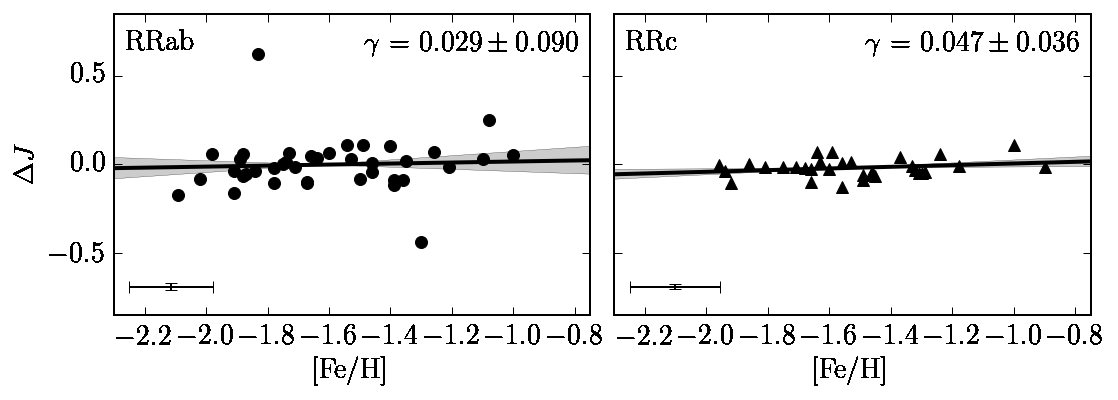

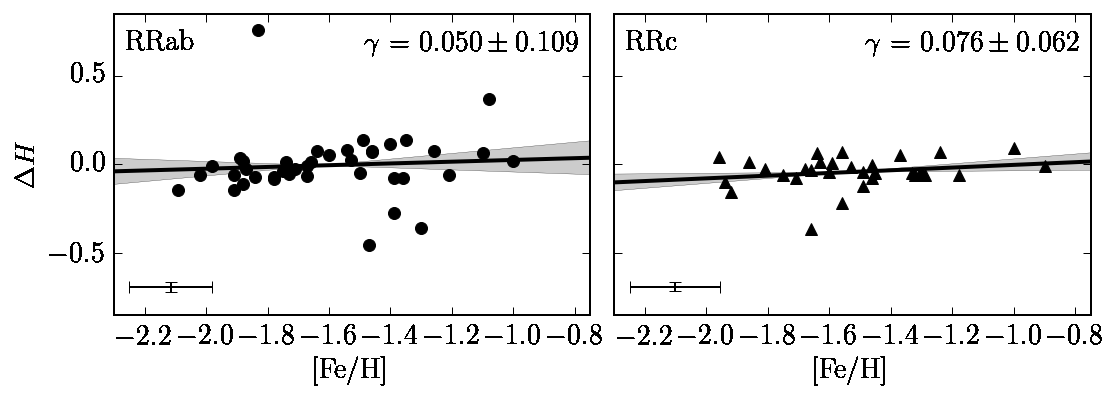

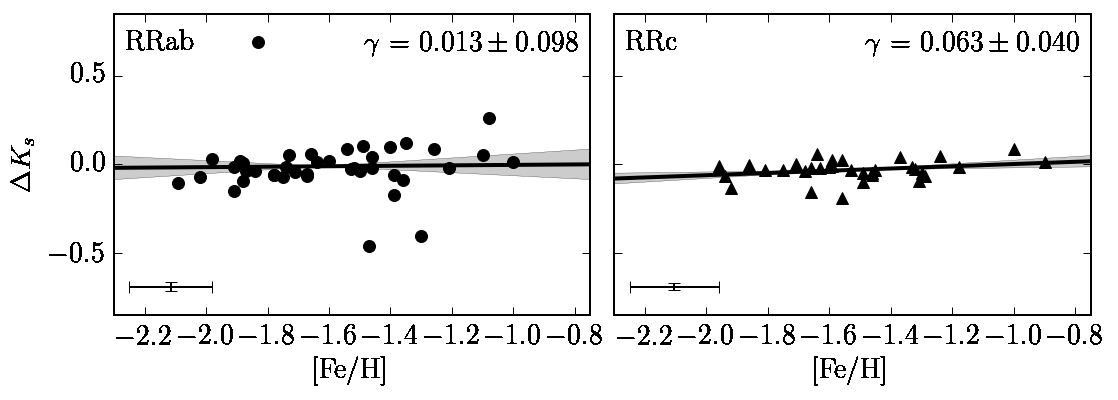

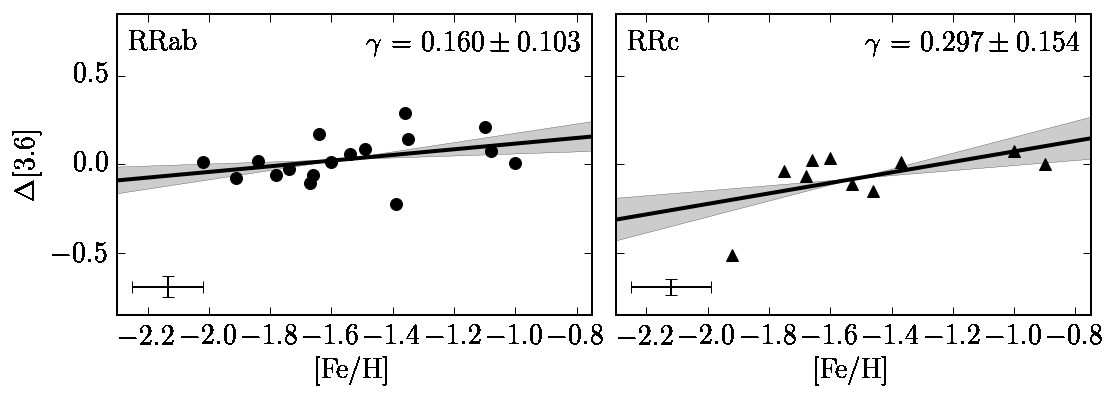

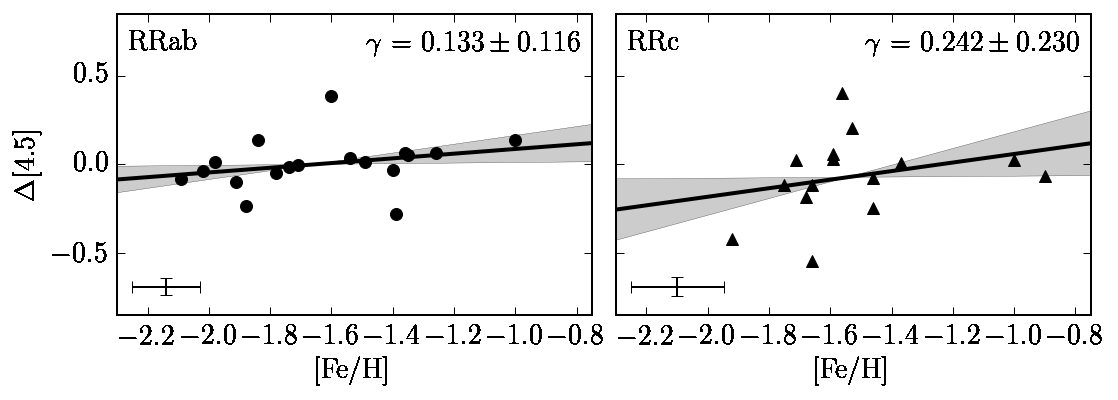

In [34]:
f = open('final_data_files/metallicity_slopes.csv','w')
f.write('filt,wav,type,slope,slope_err,zpt,zpt_err\n')
for wav,lam in [('J',1.22),('H',1.63),('K',2.19),('3',3.55),('4',4.493)]:
    results = make_plot(wav,df,lam)
    f.write('\n'.join(results)+'\n')
f.close()

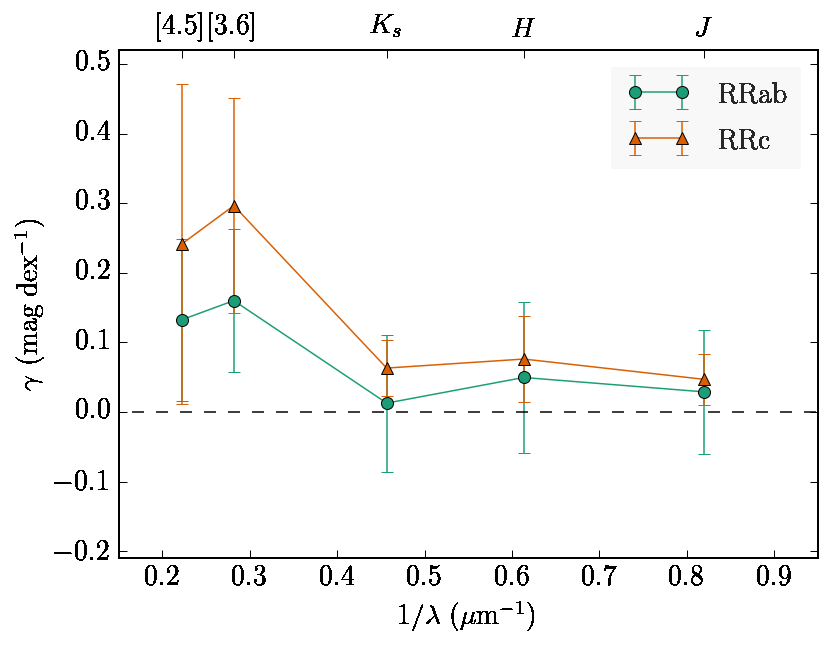

In [35]:
dfx = pd.read_csv('final_data_files/metallicity_slopes.csv')
fig = plt.figure(figsize=(6,4.7))
#for fehtype in dfx.fehtype.unique():
for mode in dfx['type'].unique():
    dfn = dfx[(dfx['type'] == mode)]
    if mode == 'RRab':
        ppl.errorbar(1/dfn['wav'], dfn['slope'], yerr=dfn['slope_err'].values, fmt='o-',
                     label='{}'.format(mode))
    else:
        ppl.errorbar(1/dfn['wav'], dfn['slope'], yerr=dfn['slope_err'].values, fmt='^-',
                     label='{}'.format(mode))
plt.xlim(0.15,0.95)
plt.ylim(-1.05,0.47)
plt.xlabel(r'$1/\lambda\ (\mu\mathrm{m}^{-1})$')
plt.ylabel(r'$\gamma$ (mag dex$^{-1}$)')
plt.hlines(0,0,1,'k',linestyle='--',linewidth=0.75)
ppl.legend()
ax2 = plt.twiny()
ax2.set_xlim(0.15,0.95)
ax2.set_ylim(-0.21,0.52)
#ax2.xaxis.set_ticks_position('none')
ppl.plot(ax2,[],[])
ax2.set_xticks(1/dfn['wav'])
ax2.set_xticklabels(['$J$', '$H$',  '$K_s$', '[3.6]', '[4.5]'])
plt.tight_layout()
plt.savefig('final_plots/metallicity_slope_vs_wavelength.pdf')